In [1]:
import numpy as np
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
scale=3.
mean=0.
p=1.5
noise_type = 'frechet'

dim = 1
weight = np.random.randn(dim+1)
weight = weight/np.sqrt(weight.dot(weight))
    
if noise_type == 'weibull':
    weibull_noise = BothSideWeibullNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: weight.dot([1,x]) + weibull_noise.sample()
elif noise_type == 'pareto':
    pareto_noise = BothSideParetoNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: weight.dot([1,x]) + pareto_noise.sample()
elif noise_type == 'frechet':
    frechet_noise = BothSideFrechetNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: weight.dot([1,x]) + frechet_noise.sample()
    
x_list = np.linspace(-10.,10., 10000)
mean_list = [weight.dot([1,x]) for x in x_list]

x_data = 5.*np.random.randn(50)
y_data = [get_observation(x) for x in x_data]

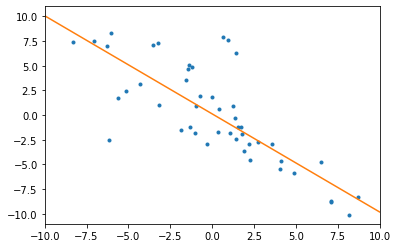

In [3]:
plt.plot(x_data, y_data, '.')
plt.plot(x_list, mean_list, '-')

plt.xlim([-10.,10.])
plt.ylim([-11.,11.])
plt.show()

# Regularized Linear Regression

In [4]:
lam = 1.

X = np.array([[1,x] for x in x_data])
A = X.T.dot(X) + lam*np.eye(dim+1)

weight_hat = np.linalg.inv(A).dot(X.T.dot(y_data))
est_mean_list = np.array([weight_hat.dot([1,x]) for x in x_list])

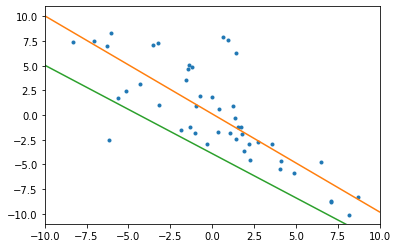

In [14]:
plt.plot(x_data, y_data, '.')
plt.plot(x_list, mean_list, '-')
plt.plot(x_list, est_mean_list, '-')

plt.xlim([-10.,10.])
plt.ylim([-11.,11.])
plt.show()

# Catoni's M Linear Regression

In [6]:
import scipy.optimize

# Static helper functions for Catoni's estimator
def _cal_ap(p):
    if p == 2:
        return 1./2.
    else:
        ap = (2.*(((2.-p)/(p-1.)) ** (1.-(2./p))) + ((2.-p)/(p-1.))**(2.-(2./p))) **(-p/2.)
        return ap

def _cal_psi(x, p):
    ap = _cal_ap(p)
    psi = np.sign(x)*np.log(ap*(abs(x)**p) + np.sign(x)*x + 1.)
    return psi

In [7]:
beta = 10.
remainder = lambda x: np.sum(_cal_psi(beta*np.abs([x.dot([1,z]) - y for z, y in zip(x_data,y_data)]),p))
sol = scipy.optimize.minimize(remainder,x0=np.zeros(dim+1,))

weight2_hat = sol.x
est_mean2_list = np.array([weight2_hat.dot([1,x]) for x in x_list])

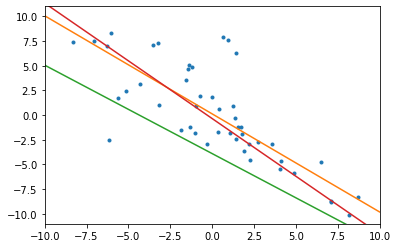

In [8]:
plt.plot(x_data, y_data, '.')
plt.plot(x_list, mean_list, '-')
plt.plot(x_list, est_mean_list, '-')
plt.plot(x_list, est_mean2_list, '-')

plt.xlim([-10.,10.])
plt.ylim([-11.,11.])
plt.show()

# Truncated Linear Regression

In [31]:
lam = 0.1
beta = 10.

X = np.array([[1,x] for x in x_data])
A = X.T.dot(X) + lam*np.eye(dim+1)
Y = np.array(y_data)
U, s, VT = np.linalg.svd(X)
B = VT.T.dot(np.diag(1/np.sqrt((s**2 + lam)))).dot(VT)
C = VT.T.dot(np.diag(s/np.sqrt((s**2 + lam)))).dot(U[:,:dim+1].T)

weight3_hat = B.dot([np.sum(np.where(np.abs(c*Y) <= beta, c*Y, 0.)) for c in C])
est_mean3_list = np.array([weight3_hat.dot([1,x]) for x in x_list])

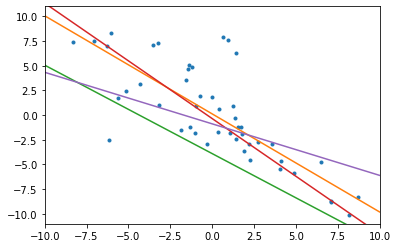

In [32]:
plt.plot(x_data, y_data, '.')
plt.plot(x_list, mean_list, '-')
plt.plot(x_list, est_mean_list, '-')
plt.plot(x_list, est_mean2_list, '-')
plt.plot(x_list, est_mean3_list, '-')

plt.xlim([-10.,10.])
plt.ylim([-11.,11.])
plt.show()

# Meadian Linear Regression

# PRo

In [24]:
lam = 0.1
beta = 1

X = np.array([[1,x] for x in x_data])
A = X.T.dot(X) + lam*np.eye(dim+1)
Y = np.array(y_data)
U, s, VT = np.linalg.svd(X)
B = VT.T.dot(np.diag(1/np.sqrt((s**2 + lam)))).dot(VT)
C = VT.T.dot(np.diag(s/np.sqrt((s**2 + lam)))).dot(U[:,:dim+1].T)

weight5_hat = B.dot([np.sum(beta*_cal_psi(c*Y/beta,p)) for c in C])
est_mean5_list = np.array([weight5_hat.dot([1,x]) for x in x_list])

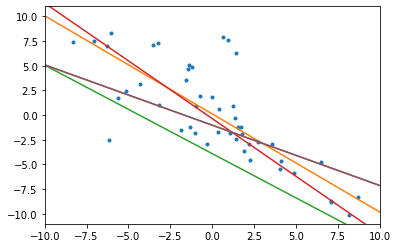

In [25]:
plt.plot(x_data, y_data, '.')
plt.plot(x_list, mean_list, '-')
plt.plot(x_list, est_mean_list, '-')
plt.plot(x_list, est_mean2_list, '-')
plt.plot(x_list, est_mean3_list, '-')
plt.plot(x_list, est_mean5_list, '-')

plt.xlim([-10.,10.])
plt.ylim([-11.,11.])
plt.show()

In [26]:
np.mean(np.abs(mean_list - est_mean_list))

4.0187524488721

In [27]:
np.mean(np.abs(mean_list - est_mean2_list))

0.939629599551387

In [28]:
np.mean(np.abs(mean_list - est_mean3_list))

2.0827460672666644